In [267]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## OKC data 
https://theblog.okcupid.com/race-and-attraction-2009-2014-107dcbb4f060
https://www.thecut.com/2014/09/new-okcupid-data-on-race-is-pretty-depressing.html
https://theblog.okcupid.com/how-your-race-affects-the-messages-you-get-39c68771b99e
https://theblog.okcupid.com/race-and-attraction-2009-2014-107dcbb4f060

The code below loads the Excel file and selects the data within the first sheet. 

In [477]:
x1 = pd.ExcelFile('../data/response_data.xlsx')  
x1.sheet_names
df = x1.parse("Sheet1", header = 17, usecols = [0,1,2,3,4,5,6,7,8])
df.head()

,Date,Contact,Length,Ethnicity,Response,Age,Meeting,Single,Match
0,2015-05-01,NaN,15,W,1.0,38.0,1.0,NaN,NaN
1,2015-05-07,NaN,10,U,NaN,NaN,NaN,NaN,NaN
2,2015-05-15,NaN,11,W,NaN,30.0,NaN,1.0,87.0
3,2015-05-18,NaN,20,A,NaN,25.0,NaN,1.0,87.0
4,2015-05-18,NaN,9,U,NaN,NaN,NaN,NaN,NaN


In [478]:
#Change W to White, U to Unkown, L to Latina, A to Asian, B to Black
df.Ethnicity.replace( 'U', 'Unknown', inplace = True)
df.Ethnicity.fillna( 'Unknown' , inplace = True)
df.Ethnicity.replace( 'W', 'White', inplace = True)
df.Ethnicity.replace( 'L', 'Latina', inplace = True)
df.Ethnicity.replace( 'A', 'Asian', inplace = True)
df.Ethnicity.replace( 'B', 'Black', inplace = True)

Define a function for returning percentages

In [479]:
def perc(x, y):
    z = x / y 
    return "{:.1%}".format(z)

## Response rate for all contacted 

In [480]:
perc(df.Response.sum(), len(df.loc[ df.Contact != 1  , 'Contact']))  #substracts rows where I was contacted first 

'22.6%'

## Percentage of in person meetings 

In [481]:
perc(df.Meeting.sum(),  len(df)) 

'1.5%'

## Average age differential of people contacted 

In [513]:
 int ( 37 - df.loc[(df.Contact != 1)  , 'Age'].mean() )  #subtracts age from avg

4

## Response % from Whites

In [484]:
contacted = len(df.loc[ (df.Contact != 1) & (df.Ethnicity == 'White') , 'Ethnicity'])
replied = len(df.loc[ (df.Contact != 1) & (df.Ethnicity == 'White') & (df.Response == 1), 'Ethnicity'])
perc( replied, contacted)

'20.4%'

In [517]:
#Build a function to calculate rate above 
def reply_rate(str): 
    contacted = len(df.loc[ (df.Contact != 1) & (df.Ethnicity == str) , 'Ethnicity'])
    replied  = len(df.loc[ (df.Contact != 1) & (df.Ethnicity == str) & (df.Response == 1), 'Ethnicity'])
    return '{} = {}'.format(str,  perc(replied, contacted))

## Response % by group

In [518]:
reply_rate('White'), reply_rate('Latina'), reply_rate('Asian'), reply_rate('Black'), reply_rate('Unknown')

('White = 20.4%',
 'Latina = 19.2%',
 'Asian = 42.9%',
 'Black = 50.0%',
 'Unknown = 15.7%')

## Response rate by group
I included the unkown data because in some of the messages I was able to determine (either by user ID or chat context) group identification.

## Rate of groups contacted (White, Latina, Asian, Black)
Count the number of instances for a group, where I initiated contact, and divide by dataframe length. For this comparison it makes sense not to include the Unknown group because it overwhelms the rates. It could be that the unknown values contain a skewed preference towards one group; however, there is no way to know that. 

In [487]:
df['Ethnicity'].value_counts()

Unknown    110
White       51
Latina      26
Asian       14
Black        4
Name: Ethnicity, dtype: int64

In [489]:
def group_rate(str):
    no_unknown = len(df) - len(df.loc[ df.Ethnicity == 'Unknown' , 'Ethnicity']) #subtracts unknown values from df length 
    group_count = len(df.loc[ df.Ethnicity == str, 'Ethnicity'])  
    return "{} = {}".format(str, perc(group_count,no_unknown))   #calls on former perc() function 

group_rate('White'), group_rate('Latina'), group_rate('Asian'), group_rate('Black')

('White = 53.7%', 'Latina = 27.4%', 'Asian = 14.7%', 'Black = 4.2%')

How does this compare to OKC's overall demographic makeup? Did I favor one group over the other, or is this typical of random sampling? 

According to Quantcast (2009) OKC demographics: <br> White =  91%, Hispanic = 3%,  Asian = 3%, Black = 2%  

We could compare these numbers to the California and US census values. There is no reason to believe OKC demographics scaled accordingly over time, but it gives us something to compare. 


If we look at 2010 Census data for California: <br> White = 40.1%, Hispanic = 37.6%, Asian = 13%, Black = 6.2%. 

For the US: <br> White = 63.7%, Latino = 16.3%, Asian = 4.7%, Black = 12.2%

https://www.census.gov/census2000/pdf/ca_tab_1.PDF <br>
http://www.census.gov/prod/cen2010/briefs/c2010br-02.pdf


## Percent Bias against OKC data

In [490]:
groups = ['White', 'Latina', 'Asian', 'Black']
my_rates = [53.7, 27.4, 14.7,4.2]
okc_data = [91,3,3,2] 
cal_data = [40.1,37.6,13,6.2] 
us_data = [63.7,16.3,4.7,12.2]

def pbias(x,y,z):    #inputs are group, my data, reference data
    dif = [ '%.0f' % ( (i - j)/j*100 )  for i, j in zip(y, z)] #finds the difference between previous lists 
    bias = { 'Group' : x, 'Rel Bias %': dif }
    return bias

pbias(groups, my_rates, okc_data)

{'Group': ['White', 'Latina', 'Asian', 'Black'],
 'Rel Bias %': ['-41', '813', '390', '110']}

If the 2009 OKC demographics scaled to 2017, then I would have a negative bias against White, and a positive bias towards every other group. The largest bias would be towards Latinas. 

## Percent Bias against California demographics

In [492]:
pbias(groups, my_rates, cal_data)

{'Group': ['White', 'Latina', 'Asian', 'Black'],
 'Rel Bias %': ['34', '-27', '13', '-32']}

If California demographics were representative of OKC California demographics, then I would have a slightly negative bias towards Latinas and Blacks, with slight bias towards Whites and Asians. 

## Percent Bias against US demographics

In [493]:
pbias(groups, my_rates, us_data)

{'Group': ['White', 'Latina', 'Asian', 'Black'],
 'Rel Bias %': ['-16', '68', '213', '-66']}

## Percentage of messages where they initiated first contact 

In [494]:
perc( df.Contact.sum(), len(df) )

'2.9%'

## Percentage of Whites initiating first contact

In [495]:
perc( df.loc[(df.Contact == 1) & (df.Ethnicity == 'White') , 'Contact'].sum(), df.Contact.sum() )

'33.3%'

In [504]:
def first(str):
    messages = df.loc[(df.Contact == 1) & (df.Ethnicity == str) , 'Contact'].sum()
    return '{} = {}'.format( str, perc( messages, df.Contact.sum() ) ) 

## Percentage of messages where they initiated first contact 

In [506]:
first("White"), first("Latina"), first("Asian"), first("Black"), first('Unknown')

('White = 33.3%',
 'Latina = 0.0%',
 'Asian = 0.0%',
 'Black = 33.3%',
 'Unknown = 33.3%')

## My response rate upon being messaged first 

In [509]:
perc( df.loc[df.Contact == 1, 'Response'].sum(), df.Contact.sum() )

'100.0%'

I replied to everyone that messaged me.

## Histogram of Match % messaged 

'Match % average of 77 with a median of 80'

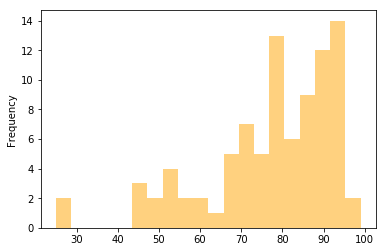

In [511]:
df.Match.plot.hist(alpha = .5, color = 'orange', bins=20);
match_mean = "%.0f" % df.Match.mean()
match_median = "%.0f" % df.Match.median()
'Match % average of {} with a median of {}'.format(match_mean, match_median)

## Histogram of Match % messaged and responded
This data does not include people who initiated contact. The graph below demonstrates that no one messaged above the 90% Match rating responded. *Not all of the data had Match %, thus the frequencies are small.

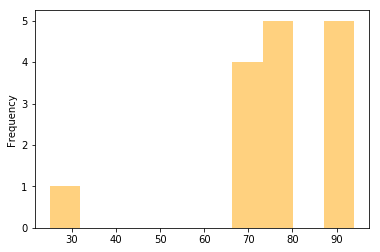

In [512]:
dfm =  df.loc[(df.Response == 1) & (df.Contact != 1), 'Match']
dfm.plot.hist(bins = 10, alpha = .5, color = 'orange');
#Need to find this rates too

'Length of average message is 16 words, with a median of 13 words'

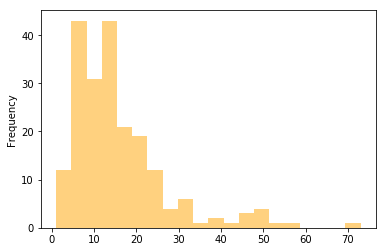

In [469]:
df.Length.plot.hist(bins=20, alpha = .5, color = 'orange');
length_mean = "%.0f" % df.Length.mean()
length_median = "%.0f" % df.Length.median()
'Length of average message is {} words, with a median of {} words'.format(length_mean, length_median)

'Length of average message that received a response is 15 words, with a median of 13 words'

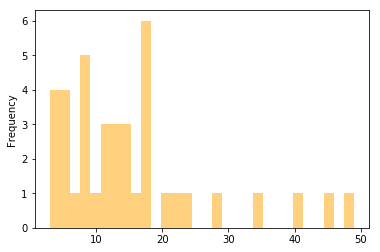

In [474]:
dfl =  df.loc[(df.Response == 1) & (df.Contact != 1), 'Length']
dfl.plot.hist(bins = 30, alpha = .5, color = 'orange');
len_mean = "%.0f" % dfl.mean()
len_median = "%.0f" % dfl.median()
'Length of average message that received a response is {} words, with a median of {} words'.format(len_mean, len_median)

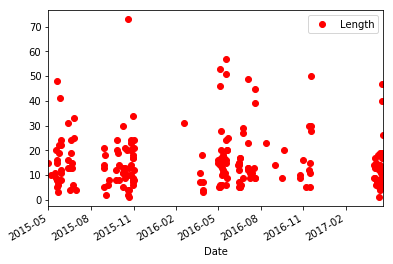

In [475]:
df.plot( x='Date', y='Length', style = 'ro'); #displays messages and length of messages over time

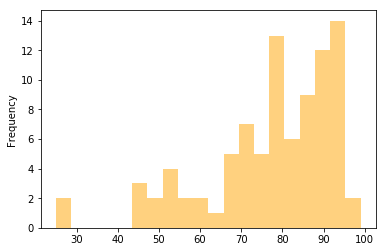

In [476]:
df.Match.plot.hist(alpha = .5, color = 'orange', bins=20);

## Conclusion 
Use Jim Rohn quote on investing inself. That would be a much better use of time. 

How many words does the average person type per minute: 40 
For one date 100*messages* 16 words/message * minute/40 words 1h/60min + 100*(2+1)min* 1h/60min + Find/Read/Write
2 min to find, 2 min read and decide to message, 1 min to look at pics, 2 min to come up with a message to write 

okcupid suggests for 20% 6 messages / hour

In [266]:
100*1/6

16.666666666666668

https://theblog.okcupid.com/online-dating-advice-optimum-message-length-8a2887c3d6ca

https://medium.com/@sm_app_intel/conquer-love-with-these-crucial-dating-app-statistics-2870ec5493cd

http://time.com/3302251/9-ugly-truths-big-data-ok-cupid-book/

http://www.giveyourhandabreak.com/ethnicity/
